# Lab 4: Deep Sequence Modeling

The forth lab session is about data that have a sequential structure that must be taken into account.

In [25]:
from __future__ import print_function
import tensorflow as tf
import os, json, re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import pandas as pd
%matplotlib inline

# 4.1 Deal with sequential data
<img src="https://drive.google.com/uc?id=1k6HwtWlMTkVJFuyBpeBGF2sApqxR-KRc" width="600px" align="right"><br>
In this lab we see Deep Learning models that can process sequential data (text, timeseries,..).<br>
These models don’t take as input raw text: they only work with numeric tensors; **vectorizing** text is the process of transforming text into numeric tensors.<br><br><br>
The different units into which you can break down text (words, characters) are called tokens; then if you apply a tokenization scheme, you associate numeric vectors with the generated tokens.<br>
These vectors, packed into sequence tensors, are fed into Deep Neural Network.<br>
There are multiple ways to associate a vector with a token: we will see One-Hot Encoding and Token Embedding.<br>
In this section we are going to deal with:
* 3.1.1 One-Hot Encoding
* 3.1.2 Word embedding

## 4.1.1 One-Hot Encoding
One-Hot Encoding consists of associating a unique integer index with every word and then turning this integer index $i$ into a binary vector of size $N$ (the size of the vocabulary); the vector is all zeros except for the $i$-th entry, which is 1.
<img src="https://drive.google.com/uc?id=1OzK9t_WXQsaDuZoOTQSksLuNMubXm0gc" width="400px">

#### Try to perform One-Hot Encoding using Tokenizer
Keras provides the Tokenizer class for preparing text documents for DL.<br>
The Tokenizer must be constructed and then fit on either raw text documents or integer encoded text documents

In [26]:
# define 4 documents
docs = ['Well done!','Good work','Great effort','nice work']

# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(docs)


encoded_docs = tokenizer.texts_to_matrix(docs, mode='count')
print(encoded_docs)

[[0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1.]]


Some problems related to this kind of encoding are sparsity of the solution and the high dimensionality of the vector encoding of the tokens.

## 4.1.2 Word embedding
<img src="https://drive.google.com/uc?id=1YRcQ1_5n8Qay0GFoSLVrNcEKWeik5G3S" width="400px" align="right"><br>
The vector obtained from word embedding is dense and has lower dimensionality w.r.t One-Hot Encoding vector; the dimensionality of embedding space vector is an hyperparameter.<br>
There are two ways to obtain word embeddings:<br>
* May be learned jointly with the network
* May use pre-trained word vectors (Word2Vec, GloVe,..)


Word embeddings maps human language into a geometric space; in a reasonable embedding space synonyms are embedded into similar word vectors and the geometric distance between any two word vectors reflects the semantic distance between the associated words (words meaning different things are embedded at points far away from each other, whereas related words are closer).<br>
How good is a word-embedding space depends on the specific task.<br>
It is reasonable to learn a new embedding space with every new task: with backpropagation and Keras it reduces to learn the weights of the Embedding layer.

### Learning Word Embeddings with the embedding layer
#### Load imdb dataset
This dataset contains movies reviews from IMDB, labeled by sentiment(positive/negative); reviews have been preprocessed, and each review is encoded as a sequence of word indexes(integers).<br>
https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

In [27]:
max_features = 10000
maxlen = 50

imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

#### Show the size of vocabulary and the most frequent words

In [28]:
word_to_index = imdb.get_word_index()

vocab_size = len(word_to_index)
print('Vocab size : ', vocab_size)


words_freq_list =words_freq_list = []
[]
for (k,v) in imdb.get_word_index().items():
    words_freq_list.append((k,v))

sorted_list = sorted(words_freq_list, key=lambda x: x[1])

print("50 most common words: \n")
print(sorted_list[0:50])

Vocab size :  88584
50 most common words: 

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20), ('not', 21), ('you', 22), ('are', 23), ('his', 24), ('have', 25), ('he', 26), ('be', 27), ('one', 28), ('all', 29), ('at', 30), ('by', 31), ('an', 32), ('they', 33), ('who', 34), ('so', 35), ('from', 36), ('like', 37), ('her', 38), ('or', 39), ('just', 40), ('about', 41), ("it's", 42), ('out', 43), ('has', 44), ('if', 45), ('some', 46), ('there', 47), ('what', 48), ('good', 49), ('more', 50)]


In [29]:
word_to_index['otherwise']

897

# 4.2 Recurrent Neural Network
Here https://colah.github.io/posts/2015-08-Understanding-LSTMs/ you can find a clear explanation about RNNs and LSTMs; the following is a summary of the main concepts.


A major characteristic of some neural networks, as ConvNet, is that they have no memory: each input is processed independently, with no state kept in between inputs. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in.<br>
A recurrent neural network (RNN) adopts the same principle but in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far.

<img src="https://drive.google.com/uc?id=1RaDXXygc0HJv6YyIAjU4_Nbw1bXzAhAJ" width="650px"><br>




Each input $x_{i=t-1, t, t+1, ..}$ is combined with the internal state and then is applied an activation function (e.g. $tanh$); then the output is computed $h_{i=t-1, t, t+1, ..}$ and the internal state is updated.<br>
In many cases, you just need the last output ($h_{i=last t}$ at the end of the loop), because it already contains information
about the entire sequence.
<img src="https://drive.google.com/uc?id=1RtulDLKQnzZTSbBsD2n7TIlRVEaESB8o" width="550px">


#### Create the model
In the following sections we will develop different models. Be careful to the fact that we are dealing with a binary classification problem!

In [30]:
from tensorflow.keras.layers import Dense, SimpleRNN
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))

# Complete the model, it should be made by at least:
# 1 SimpleRNN layer
model.add(SimpleRNN(16))
# 1 Dense layer
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          160000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,545
Trainable params: 160,545
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [31]:
# Train your model here


history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.3)




Epoch 1/10
137/137 [==============================] - 45s 312ms/step - loss: 0.6366 - acc: 0.6240 - val_loss: 0.5694 - val_acc: 0.7015
Epoch 2/10
137/137 [==============================] - 12s 91ms/step - loss: 0.4527 - acc: 0.7990 - val_loss: 0.4481 - val_acc: 0.7944
Epoch 3/10
137/137 [==============================] - 10s 75ms/step - loss: 0.3559 - acc: 0.8546 - val_loss: 0.4359 - val_acc: 0.7993
Epoch 4/10
137/137 [==============================] - 10s 71ms/step - loss: 0.2953 - acc: 0.8843 - val_loss: 0.4316 - val_acc: 0.8060
Epoch 5/10
137/137 [==============================] - 9s 67ms/step - loss: 0.2450 - acc: 0.9075 - val_loss: 0.4534 - val_acc: 0.7984
Epoch 6/10
137/137 [==============================] - 8s 59ms/step - loss: 0.1974 - acc: 0.9286 - val_loss: 0.5231 - val_acc: 0.7888
Epoch 7/10
137/137 [==============================] - 9s 68ms/step - loss: 0.1591 - acc: 0.9443 - val_loss: 0.5281 - val_acc: 0.7939
Epoch 8/10
137/137 [==============================] - 9s 64ms/st

In [32]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

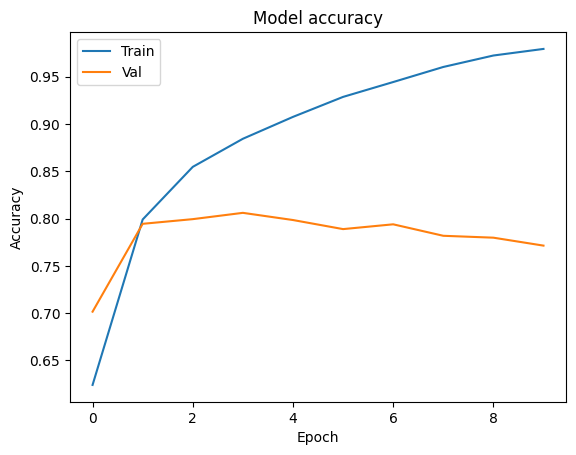

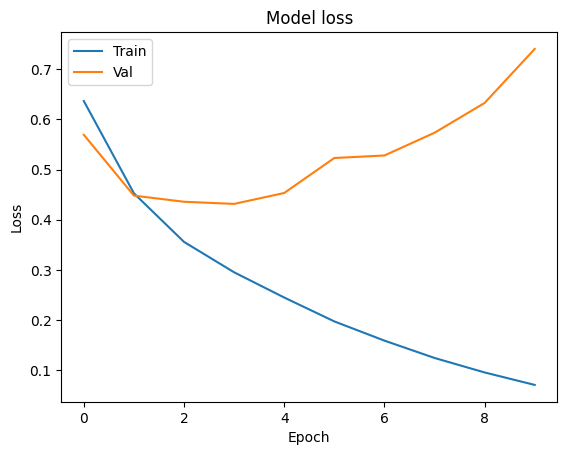

In [33]:
plot_history(history)

#### Evaluate the model

In [34]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

782/782 [==============================] - 6s 8ms/step - loss: 0.7333 - acc: 0.7689
Test accuracy: 0.769, Test loss: 0.733


#### Try to build a new model where you stack several recurrent layers.
In such a setup, you have to get all of the intermediate layers to return full sequence of outputs. This is needed to return batch size, timesteps, hidden state. By doing this the output should contain all historical generated outputs along with time stamps (3D). This way the next layer can work further on the data.

In [35]:
# Build the model. It should be made by at least:
# 1 Embedding layer
# More than 1 SimpleRNN layer, do not forget to put the return_sequences parameter to True 
# 1 Dense layer

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))
model.add(SimpleRNN(16,return_sequences=True))
model.add(SimpleRNN(8,return_sequences=True))
model.add(SimpleRNN(4))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


#### Train the model

In [36]:
# Train your model here


history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.3)




Epoch 1/10
137/137 [==============================] - 35s 236ms/step - loss: 0.6834 - acc: 0.5497 - val_loss: 0.6396 - val_acc: 0.6256
Epoch 2/10
137/137 [==============================] - 31s 226ms/step - loss: 0.5107 - acc: 0.7563 - val_loss: 0.4859 - val_acc: 0.7809
Epoch 3/10
137/137 [==============================] - 30s 221ms/step - loss: 0.3833 - acc: 0.8457 - val_loss: 0.4554 - val_acc: 0.7909
Epoch 4/10
137/137 [==============================] - 23s 170ms/step - loss: 0.3015 - acc: 0.8886 - val_loss: 0.4697 - val_acc: 0.7903
Epoch 5/10
137/137 [==============================] - 22s 164ms/step - loss: 0.2309 - acc: 0.9193 - val_loss: 0.5108 - val_acc: 0.7839
Epoch 6/10
137/137 [==============================] - 22s 159ms/step - loss: 0.1674 - acc: 0.9460 - val_loss: 0.5765 - val_acc: 0.7853
Epoch 7/10
137/137 [==============================] - 22s 163ms/step - loss: 0.1170 - acc: 0.9649 - val_loss: 0.6681 - val_acc: 0.7508
Epoch 8/10
137/137 [==============================] - 2

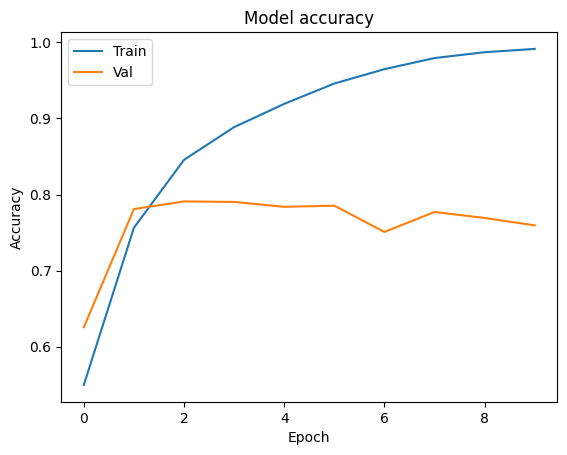

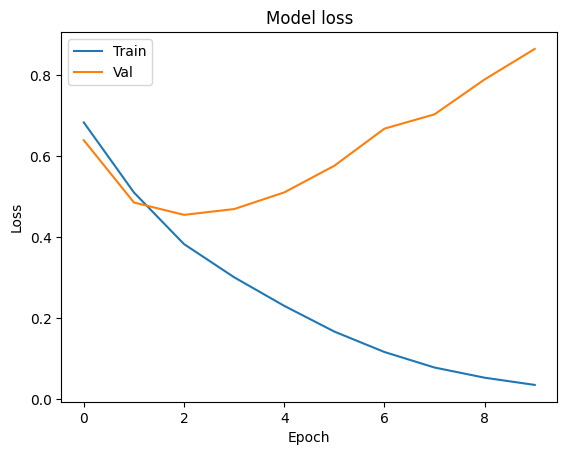

In [37]:
plot_history(history)

#### Evaluate the model

In [38]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

782/782 [==============================] - 12s 16ms/step - loss: 0.8349 - acc: 0.7647
Test accuracy: 0.765, Test loss: 0.835


**What can you say about the obtained results? What about the comparison between these results and the ones obtained in the single layer RNN?**

I noticed that with many nodes in the RNN layer, my model performed worse than with fever nodes. This could be because RNN does not deal with long-dependencies well, and therefore more nodes can lead to issues. Another reason may be that the model is overfitted in the training phase. I see that the validation data does worse than the training data after a few epochs, which is a sign of overfitting. 

There is not a big difference between using one layer and several layers. The model actually seems to be doing worse with several layers. This may be because we are already overfitted, and therefore more layers will not help. 

# 4.3 Transformers
<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1-768x1082.png" width="250px" align="right"><br>

One main drawback about RNNs is their capacity to remember long-term dependencies. To alleviate this problem different models have been proposed, like Long Short Term Memories (LSTM) and Transformers.<br>
*Transformers* is one of the best available model nowadays to deal with different kind of data (text, images..) and obtain state of the art results.

The key component in the Transformer architecture is the Attention layer, that helps the encoder look at other words in the input sentence as it encodes a specific word. The attention mechanism, in theory, and given enough compute resources, have a wider window to reference from, therefore being capable of using the **entire context** of the text.




#### Create Transformer model in TensorFlow

In [39]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [40]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [41]:
from keras.api._v2.keras.layers import GlobalAveragePooling1D, Dropout
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

# Build the model. It should be made by at least:
# 1 TokenAndPositionEmbedding layer with maxlen, vocab_size and embed_dim as arguments
# 1 TransformerBlock layer with embed_dim, num_heads and ff_dim as arguments
# 1 GlobalAveragePooling1D layer
# 2 Dense layers 


modeltest = tf.keras.Sequential()
modeltest.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
modeltest.add(TransformerBlock(embed_dim, num_heads, ff_dim))
modeltest.add(tf.keras.layers.GlobalAveragePooling1D())
modeltest.add(tf.keras.layers.Dropout(0.1))
modeltest.add(tf.keras.layers.Dense(20, activation="relu"))
modeltest.add(tf.keras.layers.Dropout(0.1))
modeltest.add(tf.keras.layers.Dense(2, activation="softmax"))

modeltest.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

#### Train the model

In [42]:
# Train your model here

history = modeltest.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.3)



Epoch 1/10
547/547 [==============================] - 25s 38ms/step - loss: 0.5127 - acc: 0.7379 - val_loss: 0.4221 - val_acc: 0.8069
Epoch 2/10
547/547 [==============================] - 8s 15ms/step - loss: 0.3350 - acc: 0.8537 - val_loss: 0.4327 - val_acc: 0.8031
Epoch 3/10
547/547 [==============================] - 6s 11ms/step - loss: 0.2686 - acc: 0.8899 - val_loss: 0.5009 - val_acc: 0.7973
Epoch 4/10
547/547 [==============================] - 7s 13ms/step - loss: 0.2125 - acc: 0.9128 - val_loss: 0.5652 - val_acc: 0.7747
Epoch 5/10
547/547 [==============================] - 6s 10ms/step - loss: 0.1665 - acc: 0.9301 - val_loss: 0.6582 - val_acc: 0.7912
Epoch 6/10
547/547 [==============================] - 7s 13ms/step - loss: 0.1256 - acc: 0.9454 - val_loss: 0.8123 - val_acc: 0.7823
Epoch 7/10
547/547 [==============================] - 6s 10ms/step - loss: 0.0941 - acc: 0.9576 - val_loss: 1.0350 - val_acc: 0.7771
Epoch 8/10
547/547 [==============================] - 6s 12ms/step -

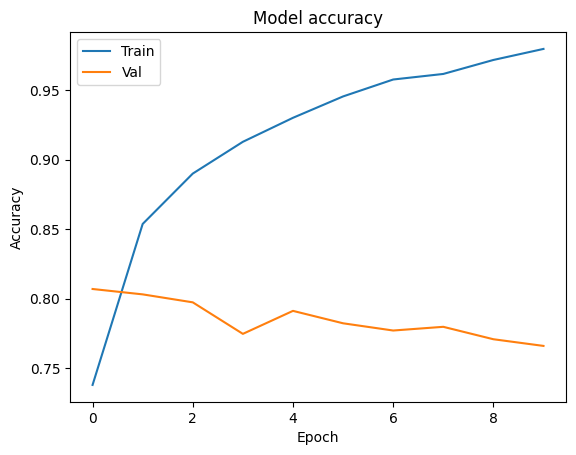

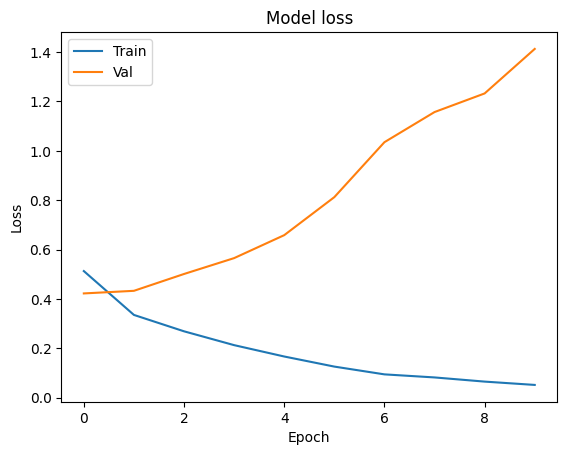

In [43]:
plot_history(history)

#### Evaluate the model

In [44]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

782/782 [==============================] - 12s 16ms/step - loss: 0.8349 - acc: 0.7647
Test accuracy: 0.765, Test loss: 0.835


# 4.4 Reuters newswire classification dataset

The reuters newswire classification dataset is a dataset of 11,228 newswires from Reuters, labeled over 46 topics. More information about the dataset and how to use it can be found here:
https://keras.io/api/datasets/reuters/

Try to build a new model dealing with this new dataset.
Try to use both the RNN and the Transfomrers approach, and select the best of them. What do you expect will be the best? Be carefull that this domain shift will imply some changes in your code as it is not a binary classification problem anymore!

In [45]:
imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=max_features)

num_classes = np.max(y_train) + 1
print(num_classes)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

46


#### Create model

In [46]:
# Build the model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features, 16))
model.add(SimpleRNN(16))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


#### Train the model

In [47]:
# Train your model here
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.3)

Epoch 1/10
99/99 [==============================] - 19s 180ms/step - loss: 3.2781 - acc: 0.3698 - val_loss: 2.6386 - val_acc: 0.4924
Epoch 2/10
99/99 [==============================] - 12s 118ms/step - loss: 2.2868 - acc: 0.5098 - val_loss: 2.1723 - val_acc: 0.4961
Epoch 3/10
99/99 [==============================] - 8s 78ms/step - loss: 1.9819 - acc: 0.5308 - val_loss: 2.0383 - val_acc: 0.5046
Epoch 4/10
99/99 [==============================] - 8s 81ms/step - loss: 1.8306 - acc: 0.5445 - val_loss: 2.0282 - val_acc: 0.5024
Epoch 5/10
99/99 [==============================] - 8s 79ms/step - loss: 1.7168 - acc: 0.5510 - val_loss: 2.0267 - val_acc: 0.5072
Epoch 6/10
99/99 [==============================] - 7s 73ms/step - loss: 1.6201 - acc: 0.5661 - val_loss: 2.0623 - val_acc: 0.5076
Epoch 7/10
99/99 [==============================] - 8s 81ms/step - loss: 1.5227 - acc: 0.5825 - val_loss: 2.0782 - val_acc: 0.5080
Epoch 8/10
99/99 [==============================] - 6s 59ms/step - loss: 1.4278

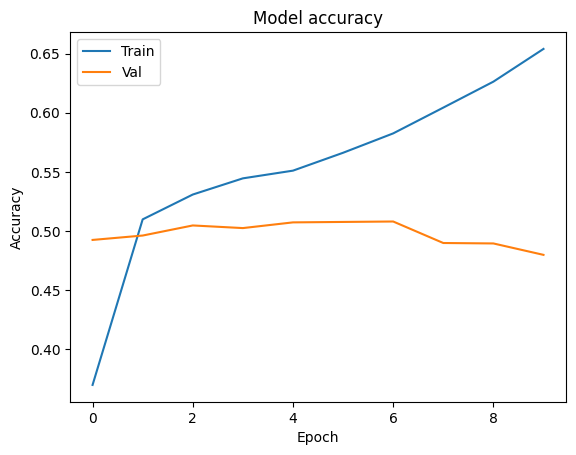

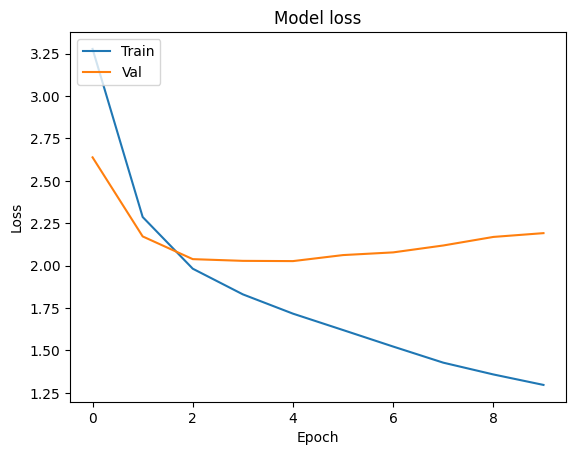

In [48]:
plot_history(history)

#### Evaluate the model

In [49]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

71/71 [==============================] - 1s 7ms/step - loss: 2.2392 - acc: 0.4902
Test accuracy: 0.490, Test loss: 2.239


In [50]:

modeltransformer = tf.keras.Sequential()
modeltransformer.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
modeltransformer.add(TransformerBlock(embed_dim, num_heads, ff_dim))
modeltransformer.add(tf.keras.layers.GlobalAveragePooling1D())
modeltransformer.add(tf.keras.layers.Dropout(0.1))
modeltransformer.add(tf.keras.layers.Dense(20, activation="relu"))
modeltransformer.add(tf.keras.layers.Dropout(0.1))
modeltransformer.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

modeltransformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

historytransformer = modeltransformer.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.3)



Epoch 1/10
99/99 [==============================] - 21s 161ms/step - loss: 2.5862 - acc: 0.3905 - val_loss: 1.9663 - val_acc: 0.5250
Epoch 2/10
99/99 [==============================] - 9s 92ms/step - loss: 1.7728 - acc: 0.5645 - val_loss: 1.5940 - val_acc: 0.5803
Epoch 3/10
99/99 [==============================] - 5s 56ms/step - loss: 1.3734 - acc: 0.6593 - val_loss: 1.4529 - val_acc: 0.6456
Epoch 4/10
99/99 [==============================] - 6s 66ms/step - loss: 1.1207 - acc: 0.7216 - val_loss: 1.4383 - val_acc: 0.6475
Epoch 5/10
99/99 [==============================] - 2s 22ms/step - loss: 0.9139 - acc: 0.7659 - val_loss: 1.4970 - val_acc: 0.6649
Epoch 6/10
99/99 [==============================] - 3s 32ms/step - loss: 0.7718 - acc: 0.8032 - val_loss: 1.5275 - val_acc: 0.6575
Epoch 7/10
99/99 [==============================] - 2s 25ms/step - loss: 0.6632 - acc: 0.8257 - val_loss: 1.5961 - val_acc: 0.6664
Epoch 8/10
99/99 [==============================] - 3s 34ms/step - loss: 0.5666 -

In [51]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %.3f, Test loss: %.3f' % (test_acc,test_loss))

71/71 [==============================] - 0s 6ms/step - loss: 2.2392 - acc: 0.4902
Test accuracy: 0.490, Test loss: 2.239


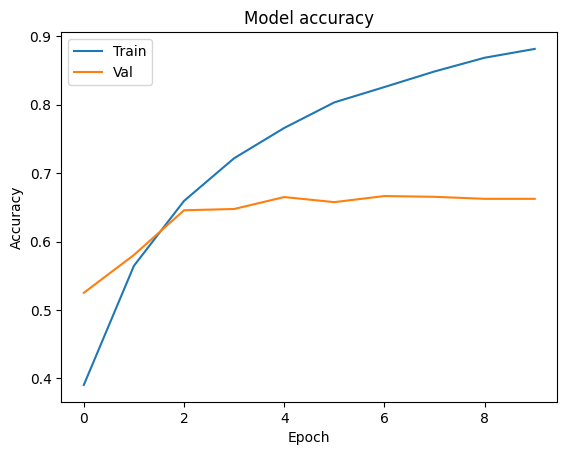

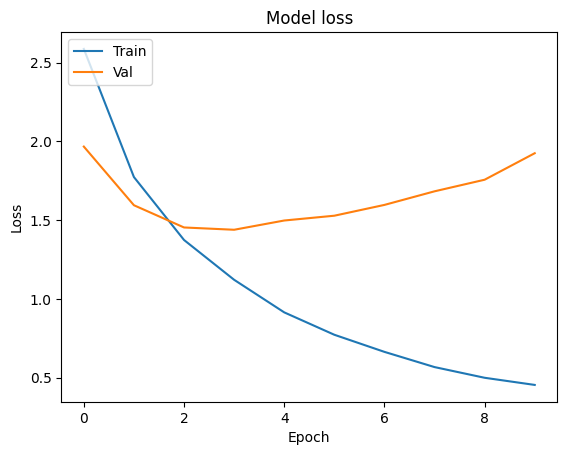

In [53]:
plot_history(historytransformer)

**Comment the results!**

As expected, the transformer performs better than the simple RNN model. I believe this is because the transformer performs better on longer dependencies, and is better at labelling the topic as it processes the entire text at once. With self-attention the transformer is able to highlight the important inputs, and therefore works better than the RNN for such a long input.  